# FCPG Test Notebook

This notebook facilitates testing the the core functionality of the FCPG tools. This steps through providing input data, converting ESRI flow directions to TauDEM flow direction, resampling and reprojecting input data, generating upstream FCPGs, creating a dictionary to cascade values from upstream to downstream hydrologic units, updating downstream parameter grids, accumulating updated grids, and making FCPGs corrected for an upstream area. The last section verifies the handling of no data values if that is desired by the user.

This notebook reads data from `./test_data` and writes data to `./test_output`. `./test_output` can be discarded after testing is complete.

Input and output grids can be examined in either ArcGIS or QGIS.

In [1]:
import FCPGtools as fc
import os
import rasterio as rs
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

# Verbose output
verbose = True

def plot(fl, cmap='Blues'): # define a helper plotting function
    src = rs.open(fl)
    tmp = src.read(1)
    try:
        tmp[tmp == src.nodata] = np.NaN
    except:
        pass
    plt.figure(figsize = (10,10))
    plt.imshow(tmp, cmap = cmap)
    
print('FCPGtools version %s loaded from %s'%(fc.__version__,fc.__path__[0]))

FCPGtools version 0.9.16 loaded from /mnt/c/Users/tbarnhart/projects/FCPGtools/FCPGtools


In [2]:
# input data sets
FDR = './data/pr_data_for_theo/fdr_orig/hdr.adf'  #FDR grid

# parameter datasets
F = './data/pr_data_for_theo/lc01forest.tif'


testFolder = './data/pr_data_for_theo'

## Convert ESRI FDR to TauDEM FDR

In [3]:
# define output paths
FDRTau = os.path.join(testFolder,'upstreamFDRtau.tif')

In [4]:
# reclassify ESRI drainage directions to TauDEM
fc.tauDrainDir(FDR, FDRTau, verbose=verbose)

Reclassifying Flow Directions...
TauDEM drainage direction written to: ./data/pr_data_for_theo/upstreamFDRtau.tif


## Resample Land Cover

In [4]:
# define output paths
Fresamp = os.path.join(testFolder,'Fresamp.tif')
fc.resampleParam(F, FDRTau, Fresamp, verbose=verbose, resampleMethod = 'near')

Flow Direction Proj4: EPSG:32161
Parameter Proj4:EPSG:32161
Flow Direction Xsize:10.0
Parameter Xsize:10.0
FDR Lower Right Corner: 295660.0, 199680.0
FDR Upper Left Corner: 105760.0, 281380.0
Param Lower Right Corner: 295660.0, 199680.0
Param Upper Left: 105760.0, 281380.0
Parameter does not require reprojection or resampling
Parameter raster copied to ./data/pr_data_for_theo/Fresamp.tif


## Accumulate the Upstream Area

In [7]:
upstreamFAC = os.path.join(testFolder,'upstreamFAC.tif') # path for the output FAC grid.

fc.tauFlowAccum(FDRTau,upstreamFAC, cores=4, verbose=verbose)

Accumulating Data...
mpiexec -n 4 aread8 -p ./data/pr_data_for_theo/upstreamFDRtau.tif -ad8 ./data/pr_data_for_theo/upstreamFAC.tif -nc


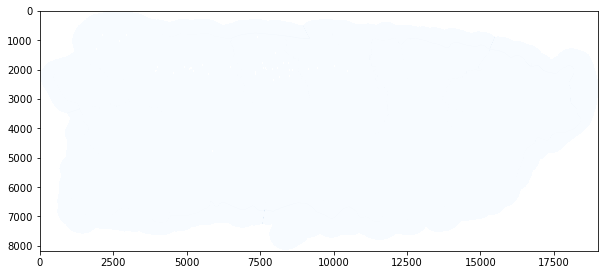

In [8]:
plot(upstreamFAC)

In [10]:
Faccum = './data/pr_data_for_theo/Faccum.tif'

In [11]:
fc.accumulateParam(F,FDRTau,Faccum,cores = 4, verbose = verbose)

Accumulating Data...
mpiexec -n 4 aread8 -p ./data/pr_data_for_theo/upstreamFDRtau.tif -ad8 ./data/pr_data_for_theo/Faccum.tif -wg ./data/pr_data_for_theo/lc01forest/hdr.adf -nc


In [12]:
fc.make_fcpg(Faccum,upstreamFAC,'./data/pr_data_for_theo/F_fcpg.tif', verbose = verbose)

Reading accumulated parameter file 2020-08-31 12:06:12.012080
Reading basin flow accumulation file 2020-08-31 12:06:15.240210
Computing CPG values 2020-08-31 12:06:18.944604
Replacing numpy nan values 2020-08-31 12:06:20.251441
Saving CPG raster 2020-08-31 12:06:20.495038
CPG file written to: ./data/pr_data_for_theo/F_fcpg.tif


### Create Update Dictionary with FCPG Values

In [22]:
# Update the dictionary with values from the upstream accumulated parameters, this should probably be a v2 function...
for fl in accumParams: # iterate through the accumulated parameters
    print(fl)
    # Parse the file names into variable names... 
    varname = fl.split('/')[-1].split('up')[0]
    if varname == 'LC':
        mod = fl.split('/')[-1].split('up')[-1].split('accum')[0]
        var = varname+mod
    else:
        var = varname
    
    # Query accumualted raster for values
    
    val = str(fc.queryPoint(x,y,fl))

    ud = fc.updateDict(updateDictFl,'14',var,[val])    

./test_output/LCup0accum.tif
./test_output/LCup1accum.tif
./test_output/LCup2accum.tif
./test_output/LCup3accum.tif
./test_output/LCup4accum.tif
./test_output/LCup5accum.tif
./test_output/LCup6accum.tif
./test_output/LCup7accum.tif
./test_output/LCup8accum.tif
./test_output/LCup9accum.tif
./test_output/LCup10accum.tif
./test_output/LCup11accum.tif
./test_output/LCup12accum.tif
./test_output/LCup13accum.tif
./test_output/LCup14accum.tif
./test_output/LCup15accum.tif
./test_output/LCup16accum.tif
./test_output/LCup17accum.tif
./test_output/LCup18accum.tif
./test_output/Pupaccum.tif


## Cascade to Downstream Area

In [23]:
downstreamFACadj = os.path.join(testFolder,'downstreamFACadj.tif')
downstreamFACweight = os.path.join(testFolder,'downstreamFACweight.tif')
fc.adjustFAC(downstreamFDRTau,downstreamFACweight,updateDictFl,downstreamFDRTau,downstreamFACadj, cores = 4, verbose = verbose)

Updating FAC weighting grid with value from 14 FAC


In [24]:
dsLCbinary.append(Pdownstream) #add the precip into the downstream land cover files

In [25]:
# create updated, unaccumulated parameter grids for the downstream region
adjDSparams = []
for fl,inGrid in zip(accumParams,dsLCbinary): # iterate through the accumulated parameters
    # Parse the file names into variable names... 
    varname = fl.split('/')[-1].split('up')[0]
    if varname == 'LC':
        mod = fl.split('/')[-1].split('up')[-1].split('accum')[0]
        var = varname+mod
    else:
        var = varname
    
    outfl = inGrid.split('.tif')[0]+'adj.tif'

    fc.adjustParam(var,inGrid,updateDictFl,outfl, verbose = verbose)
    adjDSparams.append(outfl)

Updating parameter grid with value from 14 FAC
Updating parameter grid with value from 14 FAC
Updating parameter grid with value from 14 FAC
Updating parameter grid with value from 14 FAC
Updating parameter grid with value from 14 FAC
Updating parameter grid with value from 14 FAC
Updating parameter grid with value from 14 FAC
Updating parameter grid with value from 14 FAC
Updating parameter grid with value from 14 FAC
Updating parameter grid with value from 14 FAC
Updating parameter grid with value from 14 FAC
Updating parameter grid with value from 14 FAC
Updating parameter grid with value from 14 FAC
Updating parameter grid with value from 14 FAC
Updating parameter grid with value from 14 FAC
Updating parameter grid with value from 14 FAC
Updating parameter grid with value from 14 FAC
Updating parameter grid with value from 14 FAC
Updating parameter grid with value from 14 FAC
Updating parameter grid with value from 14 FAC


In [26]:
# accumulate the downstream parameter grids
DSaccum = fc.accumulateParam_batch(adjDSparams,downstreamFDRTau,testFolder, cores=4, verbose = verbose)

In [27]:
# accumulate the downstream area
dsFCPG = fc.make_fcpg_batch(DSaccum,downstreamFACadj,testFolder, verbose = verbose)

Reading accumulated parameter file 2020-08-04 13:24:54.681012
Reading basin flow accumulation file 2020-08-04 13:24:54.693186
Computing CPG values 2020-08-04 13:24:54.702723
Replacing numpy nan values 2020-08-04 13:24:54.704373
Saving CPG raster 2020-08-04 13:24:54.704925
CPG file written to: ./test_output/LCdwn0adjaccumFCPG.tif
Reading accumulated parameter file 2020-08-04 13:24:54.721170
Reading basin flow accumulation file 2020-08-04 13:24:54.727411
Computing CPG values 2020-08-04 13:24:54.734726
Replacing numpy nan values 2020-08-04 13:24:54.735115
Saving CPG raster 2020-08-04 13:24:54.735485
CPG file written to: ./test_output/LCdwn1adjaccumFCPG.tif
Reading accumulated parameter file 2020-08-04 13:24:54.750514
Reading basin flow accumulation file 2020-08-04 13:24:54.756613
Computing CPG values 2020-08-04 13:24:54.763821
Replacing numpy nan values 2020-08-04 13:24:54.764201
Saving CPG raster 2020-08-04 13:24:54.764531
CPG file written to: ./test_output/LCdwn2adjaccumFCPG.tif
Reading

## Insert NoData values into Daymet and Verify FCPG NoData Behavior 

In [28]:
with rs.open(upstreamFDR) as src:
    fdr = src.read(1)
    fdr[fdr == src.nodata] = 0
    fdr[fdr != 0] = 1
    mask = fdr.astype(np.uint)


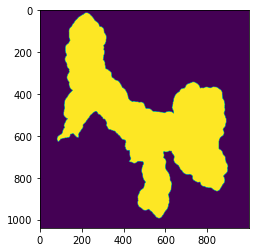

In [29]:
plt.imshow(mask)

In [30]:
#make row,col vectors of where to insert nodata values

size = 1000 # number of no data values to insert

idCol,idRow = np.where(mask == 1) # get locations of all points within the watershed

cols = np.random.choice(idCol,size = size,replace = False)
rows = np.random.choice(idRow, size = size, replace = False)

In [31]:
PupstreamNoData = os.path.join(testFolder,'PupNoData.tif') # output file name

# open source
with rs.open(Pupstream) as src:
    meta = src.meta
    noData = src.nodata
    P = src.read(1)

P[cols,rows] = noData # insert nodata values

# write out updated P grid
with rs.open(PupstreamNoData,'w',**meta) as dst:
    dst.write(P,1)

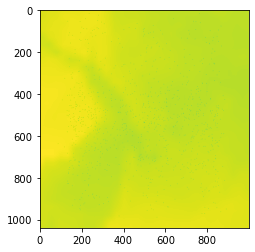

In [32]:
plt.imshow(P)

In [33]:
# accumualte the P raster with no data values added and produce the noData grids

accumRast = os.path.join(testFolder,'PupNoData_accum.tif')
outNoDataAccum = os.path.join(testFolder,'PupNoData_accumNoData.tif')
outNoData = os.path.join(testFolder,'PupNodataRast.tif')
outNoDataZero = os.path.join(testFolder,'PupNoDataZero.tif')

fc.accumulateParam(PupstreamNoData, upstreamFDRTau, accumRast,
                   outNoDataRast = outNoData, outNoDataAccum=outNoDataAccum,
                   zeroNoDataRast = outNoDataZero ,cores = 4, verbose = verbose)

Parameter Zero No Data raster written to: ./test_output/PupNoDataZero.tif
Parameter No Data raster written to: ./test_output/PupNodataRast.tif
Accumulating No Data Values
mpiexec -n 4 aread8 -p ./test_output/upstreamFDRtau.tif -ad8 ./test_output/PupNoData_accumNoData.tif -wg ./test_output/PupNodataRast.tif -nc
Parameter no data accumulation written to: ./test_output/PupNodataRast.tif
Accumulating Data...
mpiexec -n 4 aread8 -p ./test_output/upstreamFDRtau.tif -ad8 ./test_output/PupNoData_accum.tif -wg ./test_output/PupNoDataZero.tif -nc


In [34]:
# make a FCPG accounting for noData
outRast = os.path.join(testFolder,'Pup_FCPG_noData.tif')

fc.make_fcpg(accumRast,upstreamFAC, outRast, noDataRast=outNoDataAccum, verbose = verbose)

Reading accumulated parameter file 2020-08-04 13:24:56.588827
Reading basin flow accumulation file 2020-08-04 13:24:56.622248
Correcting CPG for no data values
Computing CPG values 2020-08-04 13:24:56.667706
Replacing numpy nan values 2020-08-04 13:24:56.673524
Saving CPG raster 2020-08-04 13:24:56.674500
CPG file written to: ./test_output/Pup_FCPG_noData.tif


## Decay FCPG

Produce a FCPG where values are decayed based on their distance to a stream, this can be useful for producing FCPGs with more localized values rather than basin-average values.

In [35]:
upstreamFDRTauDinf = os.path.join(testFolder,'upstreamFDRDinf.tif') # D-infinity flow direction raster
fc.d8todinfinity(upstreamFDRTau, upstreamFDRTauDinf, verbose = verbose) # convert D8 flow directions to D-inf flow directions

Reclassifying Flow Directions...
TauDEM drainage direction written to: ./test_output/upstreamFDRDinf.tif


In [36]:
streamDistRast = os.path.join(testFolder,'upstreamDist2Stream.tif') # distance to stream raster
streamRast = os.path.join(testFolder,'upstreamSTR900.tif') # stream raster
fc.makeStreams(upstreamFAC, streamRast, verbose = verbose)
fc.dist2stream(upstreamFDRTau, upstreamFAC, 900, streamDistRast, cores = 4, verbose = verbose) # compute distance to streams, use 900 cells as accumulation threshold 

Loading fac
{'driver': 'GTiff', 'dtype': 'int8', 'nodata': 99, 'width': 998, 'height': 1039, 'count': 1, 'crs': CRS.from_wkt('PROJCS["NAD_1983_Albers",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(30.0, 0.0, -1384004.9999999995,
       0.0, -30.0, 1666364.9999999963), 'tiled': True, 'compress': 'LZW', 'interleave': 'band', 'zlevel': 9, 'profile': 'GeoTIFF', 'sparse_ok': True, 'num_threads': 'ALL_CPUS', 'bigtiff': 'IF_SAFER'}
mpiexec -n

Building decay grid 2020-08-04 13:24:57.130175
Saving decay raster 2020-08-04 13:24:57.144559
Decay raster written to: ./test_output/upstreamDecay.tif


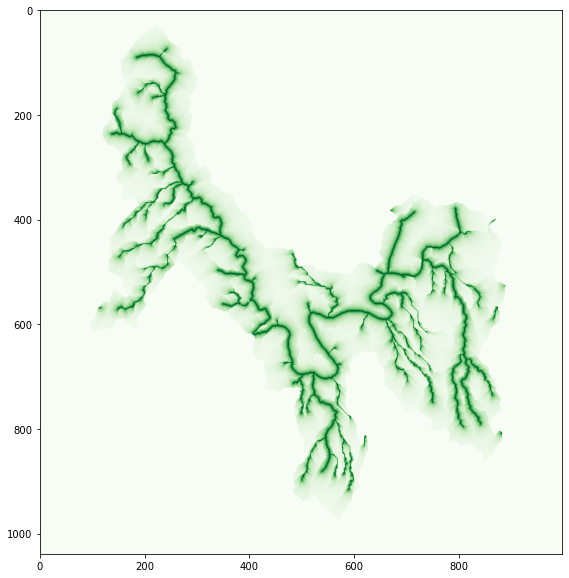

In [37]:
decayRast = os.path.join(testFolder,'upstreamDecay.tif')
k = 4 # decay coefficient
fc.makeDecayGrid(streamDistRast, k, decayRast, verbose = verbose)
plot(decayRast, cmap = 'Greens')

In [38]:
decayFAC = os.path.join(testFolder,'decayAccum.tif') # decay accumulation grid
decayParam = os.path.join(testFolder,'decayP.tif') # decay parameter accumulation grid

fc.decayAccum(upstreamFDRTauDinf, decayRast, decayParam, # perform the parameter decay accumulation
              paramRast = Pupstream, cores = 4, verbose = verbose)

Accumulating parameter
mpiexec -n 4 dinfdecayaccum -ang ./test_output/upstreamFDRDinf.tif -dm ./test_output/upstreamDecay.tif -dsca ./test_output/decayP.tif, -wg ./test_output/Pup.tif -nc
Parameter accumulation written to: ./test_output/decayP.tif


In [39]:
decayFCPG = os.path.join(testFolder,'decayFCPG.tif')
fc.maskStreams(decayParam, streamRast, decayFCPG, verbose = verbose) #Mask out pixels not on streamlines

Saving raster 2020-08-04 13:24:58.261070
CPG file written to: ./test_output/decayFCPG.tif
